In [26]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import astropy.units as u
import fsps
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_SF_spec, Gen_spec, Gen_spec_2D
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as seadddd
import os
from grizli import multifit
from grizli import model

import seaborn as sea
from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
N_GND= pd.read_pickle('../dataframes/galaxy_frames/All_GND.pkl')
N_GSD= pd.read_pickle('../dataframes/galaxy_frames/All_GSD.pkl')

N_GND= N_GND.query('fit != "Q"')
N_GSD= N_GSD.query('fit != "Q"')

In [3]:
fit_db = np.load('../data/posteriors/GSD_18933_SFfit_p1_fits.npy', allow_pickle = True).item()

In [4]:
pos_path = '../data/posteriors/'
field = 'GSD'
galaxy = 18933

fname = glob(pos_path + '{}_{}_*_fits.npy'.format(field,galaxy))[0]
fit_db = np.load(fname, allow_pickle = True).item()

fext = os.path.basename(fname).split('_')[2]

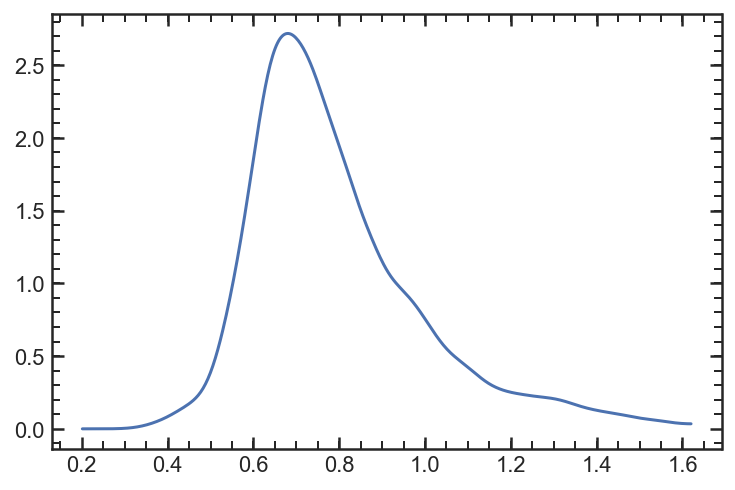

In [11]:
x = fit_db['m']
px = fit_db['Pm']

plt.plot(x,px)

In [22]:
from spec_tools import Gen_PPF, Oldest_galaxy, convert_sfh, get_agebins, Derive_SFH_weights, boot_to_posterior
class Gen_SFH(object):
    def __init__(self, field, galaxy, zgrizli, trials = 1000):
        ppf_dict = {}
        fname = glob(pos_path + '{}_{}_*_fits.npy'.format(field,galaxy))[0]
        fit_db = np.load(fname, allow_pickle = True).item()

        fext = os.path.basename(fname).split('_')[2]

        if fext == 'tabfit':
            params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm']
            P_params = ['Pa', 'Pm1', 'Pm2', 'Pm3', 'Pm4', 'Pm5', 'Pm6', 'Pm7', 'Pm8', 'Pm9', 'Pm10', 'Plm']
            x = fit_db['z']
            px = fit_db['Pz']
            rshift = x[px == max(px)][0]
            
        else:
            params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'lm']
            P_params = ['Pa', 'Pm1', 'Pm2', 'Pm3', 'Pm4', 'Pm5', 'Pm6', 'Plm']
            rshift = zgrizli
                     
        for i in range(len(params)):
            x = fit_db[params[i]]
            px = fit_db[P_params[i]]
            ppf_dict[params[i]] = Gen_PPF(x,px)

        idx = 0

        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []
        ssfr_grid = []
        t_50_grid = []
        t_80_grid = []
        t_90_grid = []
        mwa_grid = []
        
        while idx < trials:
            try:
                draw = np.zeros(len(params))

                for i in range(len(draw)):
                    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                masses = draw[1:len(params) - 1]
                lmass = draw[-1]

                time, sfr, tmax = convert_sfh(get_agebins(draw[0], binnum=len(params) - 2), masses, maxage = draw[0]*1E9)

                T=[0]
                M=[0]
                for i in range(len(time)//2):
                    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                    M.append(M[i] + mass)
                    T.append(time[i*2+1])

                sfr = sfr/ M[-1] * 10**lmass / 1E9

                lbt = np.abs(time - time[-1])[::-1]
                lbsfr = sfr[::-1]

                T=[0]
                M=[0]
                for i in range(len(lbt)//2):
                    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
                    M.append(M[i] + mass)
                    T.append(lbt[i*2+1])

                t_50_grid.append(interp1d(M/ M[-1], T)(0.5))
                t_80_grid.append(interp1d(M/ M[-1], T)(0.2))
                t_90_grid.append(interp1d(M/ M[-1], T)(0.1))

                sfrmax = np.argmax(lbsfr) 

                sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

                ssfr_grid.append(lbsfr[0] / 10**lmass)

                mwa_grid.append(np.trapz(sfr_grid[idx]*self.fulltimes,self.fulltimes)/np.trapz(sfr_grid[idx],self.fulltimes))
                idx +=1
            except:
                pass

        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])
                
        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.ma.masked_less_equal(sfr_grid,1E-10)

        weights = Derive_SFH_weights(self.SFH, sfr_grid[0:trials])
       
        ####### mwa values
        x,y = boot_to_posterior(mwa_grid[0:trials], weights)
        self.mwa, self.mwa_hci, self.mwa_offreg = Highest_density_region(y,x)
    
        ####### t values
        x,y = boot_to_posterior(t_50_grid[0:trials], weights)
        self.t_50, self.t_50_hci, self.t_50_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_80_grid[0:trials], weights)
        self.t_80, self.t_80_hci, self.t_80_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_90_grid[0:trials], weights)
        self.t_90, self.t_90_hci, self.t_90_offreg = Highest_density_region(y,x)
        
        self.t_50 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.5)
        self.t_80 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.8)
        self.t_90 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.9)

        ####### z values
        self.z_50 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_50)*u.Gyr)
        hci=[]
        for lims in self.t_50_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_50_hci = np.array(hci)
        self.z_50_offreg = np.array(self.t_50_offreg)

        self.z_80 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_80)*u.Gyr)
        hci=[]
        for lims in self.t_80_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_80_hci = np.array(hci)
        self.z_80_offreg = np.array(self.t_80_offreg)
                       
        self.z_90 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_90)*u.Gyr)
        hci=[]
        for lims in self.t_90_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_90_hci = np.array(hci)
        self.z_90_offreg = np.array(self.t_90_offreg)
                              
        x,y = boot_to_posterior(np.log10(ssfr_grid[0:trials]), weights)
        self.lssfr, self.lssfr_hci, self.lssfr_offreg = Highest_density_region(y,x)

In [6]:
N_GSD.query('id == 18933').zgrizli.values[0]

1.575318883891514

In [27]:
zgrizli = N_GSD.query('id == 18933').zgrizli.values[0]
sfh = Gen_SFH('GSD', 18933,zgrizli)

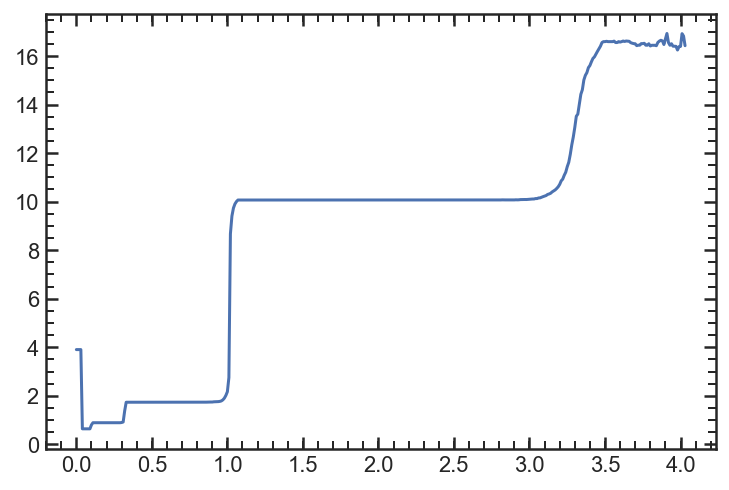

In [28]:
plt.plot(sfh.LBT, sfh.SFH)